*Based on "A simple introduction to Markov Chain Monte–Carlo sampling" by [Ravenzwaaij et al.](https://link.springer.com/content/pdf/10.3758%2Fs13423-016-1015-8.pdf):*

In [1]:
library(tidyverse)
library(viridis)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: viridisLite



I’ve been meaning to do a proper introduction to MCMC piece for a while now, but a crippling ignorance of how MCMC actually works has thus far stymied me. So this paper by Ravenwaaij et al. has pretty much been a god-send. I'm building up towards a piece experimenting with Kay Brodersen's `CausalImpact` package, so will be an intermediate signpost on that journey. 

In this post, I will walk through the basics of MCMC, and cover one of the most common implementations - Metropolis Hastings.^[I meant to do Gibbs Sampling and Differential Evolution in this post too, but as it turns out it got a little too complicated for me. I'll revisit it after I do a little more homework.]

### Introduction

Imagine we want want to know the area of a circle embedded in a 1x1 square, but in this alternate universe, we have no clue that the area of a circle can be computed analytically by applying $\pi r^2$. Is there another way we can estimate this? Well as it turns out, we can do it quite simply! All we have to do to estimate the circle's area is to drop points within this 1x1 grid randomly. By counting the proportion of points falling inside the circle, we can approximate the circle's area. 

![](/post/2020-03-01-markov-chain-monte-carlo-mcmc-metropolis-hastings_files/2020-mcmc-Circle-inscribed-in-a-square (dots).jpg)

In the case above, 70% of the points fall within the circle, giving us an estimate that the circle is 0.7cm^2^. This isn't far at all from the true value of 0.785cm^2^, and you can imagine that our approximation gets better the more points we drop in.

In a nutshell, what we've just done is a Monte Carlo simulation. That is, by drawing **random points within a given space (square)**, we approximate the density of an **unknown distribution (circle)**. The example provided above is in 2 dimensions, but you can see how this idea of randomly dropping points into an unknown distribution generalises quite easily to arbitrarily complex geometries. 

### Great, but why do I care?

Well for a huge amount of data problems, distributions tend not to be known in advance, or tend to be unsolvable by hand even if they are known. As you can imagine, if you're trying to make some decision based on an unknown distribution (say, deciding on hyperparameters in an an unknown space), this might be a tad frustrating. The beauty of Monte Carlo methods is that they allow you to make these decisions without having to know the specifics of the underlying distribution. 

### MCMC - Metropolis Algorithm

One example of how this idea is implemented is the Metropolis algorithm. This section follows the example provided in the Ravenzwaaij paper cited above almost completely.

Suppose you're a new teacher assigned to a class of 30 students whose test scores $t$ are normally distributed $t \sim N(70, 15)$. Since you're new, however, you don't actually know this. All you know is that the students' scores are normally distributed, and since they are relatively similar in ability, their test scores have variance $\sigma^2 = 15$. 

Being a principled educator, you want to know tailor your lesson plan to your students, which means that you need to get an estimate of $\mu$. Well, a simple way to get this information is simply to test your students. This is analagous to the earlier example of dropping dots in the 1x1 square; you are sampling from an unknown distribution to derive some information about the underlying data process.

Warning message:
“Ignoring unknown parameters: text”


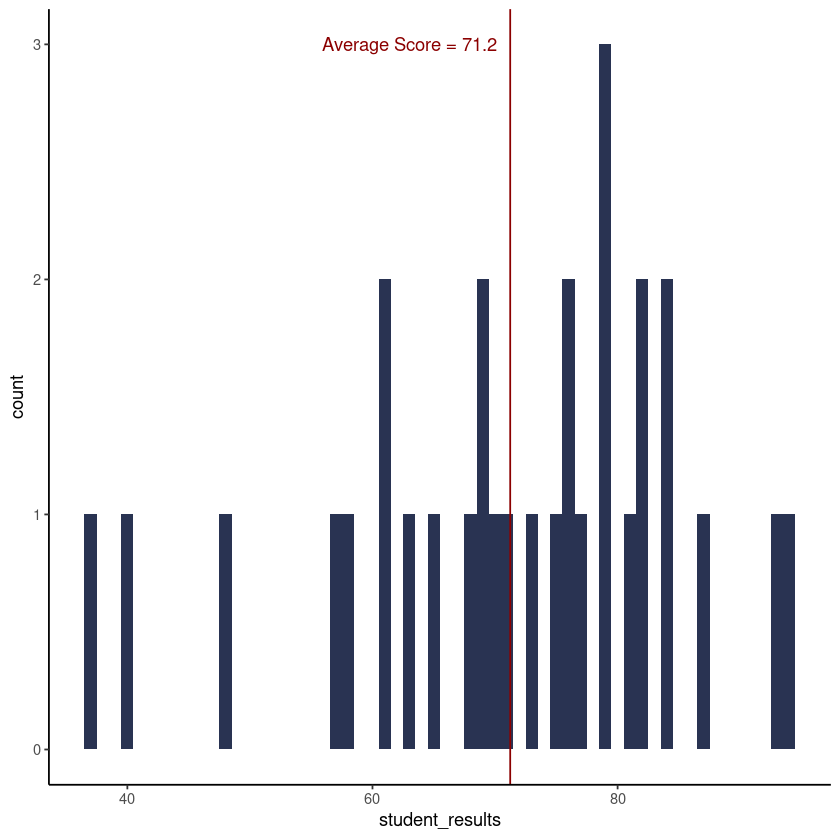

In [2]:
set.seed(1)
student_results <- rnorm(n = 30, mean = 70, sd = 15)
student_results[student_results > 100] = 100
ggplot() +
  aes(student_results) +
  geom_histogram(binwidth = 1, fill = '#293352') +
  theme_classic() +
  geom_vline(xintercept = mean(student_results), colour = 'dark red') +
  geom_text(aes(x = 63, label = 'Average Score = 71.2', y = 3), colour = 'dark red', text = element_text(size = 11))

What do you make of these results? First, you could very clearly say something about your students on *average*. Your mean score is 71.2, for example, so that's already a sensible starting point for you to assess your students' ability.

Let's assume, however, that you're told by another teacher that these students are complete idiots. He was really adamant that the average class scores can't be anything higher than $\mu = 55$, so you can't help but be swayed. How should you reconcile this with the set of test results you just received? In a frequentist world, you'd probably disregard the information provided by your colleague, and accept wholly that your students are probably around a 71.2. 
 
But put yourself in this situation. Would you really be confident enough to disregard your colleague's opinion on the basis of **1** test? What if your test results were a fluke? In a Bayesian framework, rather than choosing between your results and your colleague's opinion, you can combine both pieces of information to update what you believe to be the true value of $\mu$. This is where the Metropolis algorithm comes in.

The Metropolis Algorithm is summarised below: <br>

1. Give your best guess for the parameter(s) of interest (in this case, $\mu$). Call it $\mu_0$
2. Compute the likelihood $L_0$ of the parameter(s) being $\mu_0$ conditional on the data you observe, $P(\mu_0 | Data)$. By Bayes' rule, this is equal to $\frac{P(Data | \mu_0) \cdotp P(\mu_0)}{P(Data)}$.
3. Add a random perturbation to your parameter, and call is $\mu_1$
4. Again, compute the likelihood $L_1$ of the parameter(s) being $\mu_1$ conditional on the data you observe, $P(\mu_1 | Data)$
5. Compare the likelihood scores of hyperparameters given the data. 
    a. If $L_1$ > $L_0$, $\mu_1$ becomes your best guess
    b. If $L_1$ <= $L_0$, $\mu_1$ is chosen with probability $L_1 / L_2$
6. Repeat from step 1 for a given number of iterations

In [3]:
metropolis_algo <- function(data, proposed_mu, niter = 500){
  mu_vector = c(proposed_mu)
  new_mu = c(proposed_mu)
  for(i in 1:niter){ #do x runs
    proposal_draw = rnorm(1, 0, 5)# We define an arbitrary proposal mechanism; in this case, you draw from a normal distribution with mean 0 and sd 5
    
    # Compare the earlier proposal value for mu with the new. 
    candidate1 = sum(log(dnorm(data, proposed_mu, 15)))
    candidate2 = sum(log(dnorm(data, proposed_mu + proposal_draw, 15)))
    new_mu = c(new_mu, proposed_mu + proposal_draw)
    
    # If new proposed value gives you a higher chance of observing first_value, accept it. Otherwise, accept new proposal with probability proportionate to how much lower the posterior is compared to the original proposal. This prevents getting stuck in local maxima.
    if(candidate2 > candidate1){
      proposed_mu = proposed_mu + proposal_draw
    } else {
      if(runif(1, 0, 1) <= (exp(candidate2 - candidate1))){
        proposed_mu = proposed_mu + proposal_draw
      }
    }
    
    # Store each winning proposal to a vector
    mu_vector = c(mu_vector, proposed_mu)
  }
  return(data.frame(mu_vector) %>% cbind(new_mu))
}

Having defined the Metropolis algorithm, let's put it into practise under 3 scenarios:

* You wholly believe your test results as representative of your students' abilities, and so accept the mean of 71.2 as the starting point.

* You accept your colleague's advise about your students, and take 55 as your starting point

* You are an optimist who believes that your students are brilliant, and take 90 as your starting point

In [4]:
niter = 300
mu_frequentist <- as.data.frame(x = metropolis_algo(student_results, 71.2, niter = niter)) %>%
  `colnames<-`(c('accepted_mu', 'proposed_mu')) %>%
  mutate(status = if_else(accepted_mu == proposed_mu, 'Accepted', 'Rejected')) %>%
  mutate(startingPoint = 'Frequentist')
mu_colleague <- as.data.frame(x = metropolis_algo(student_results, 55, niter = niter)) %>%
  `colnames<-`(c('accepted_mu', 'proposed_mu')) %>%
  mutate(status = if_else(accepted_mu == proposed_mu, 'Accepted', 'Rejected')) %>%
  mutate(startingPoint = 'Colleague')
mu_optimist <- as.data.frame(x = metropolis_algo(student_results, 90, niter = niter)) %>%
  `colnames<-`(c('accepted_mu', 'proposed_mu')) %>%
  mutate(status = if_else(accepted_mu == proposed_mu, 'Accepted', 'Rejected')) %>%
  mutate(startingPoint = 'Optimist')

Notice how the next proposed value is wholly dependent on the previous proposed value? This is the Markov Chain property that provides half the "MC" in MCMC. Let's observe what happens to your beliefs about $\mu_0$ as you run this algorithm:

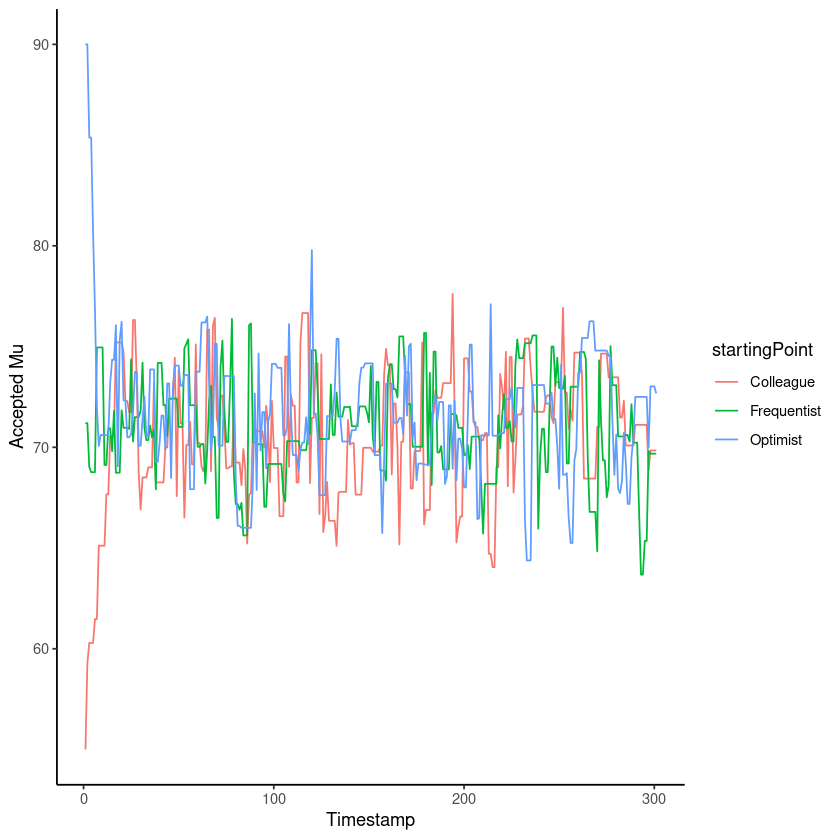

In [5]:
mu_frequentist %>%
  bind_rows(mu_colleague) %>%
  bind_rows(mu_optimist) %>%
  select(accepted_mu, startingPoint) %>%
  bind_cols(timestamp = rep(1:(niter+1), 3)) %>%
  ggplot(aes(x = timestamp, y = accepted_mu, colour = `startingPoint`)) +
  geom_line() +
  theme_classic() +
  ylab('Accepted Mu') + 
  xlab('Timestamp') 

Notice how, if your starting points are off, the algorithm takes some time to correct! We usually deal with this by discarding the first few values of the MCMC (where few is up to you to define). This practise is known as "burn in". The above showed us the path that our "accepted" values took, what about showing both acceptance and rejections? Let's take the update path under the "Optimist" view as an example:

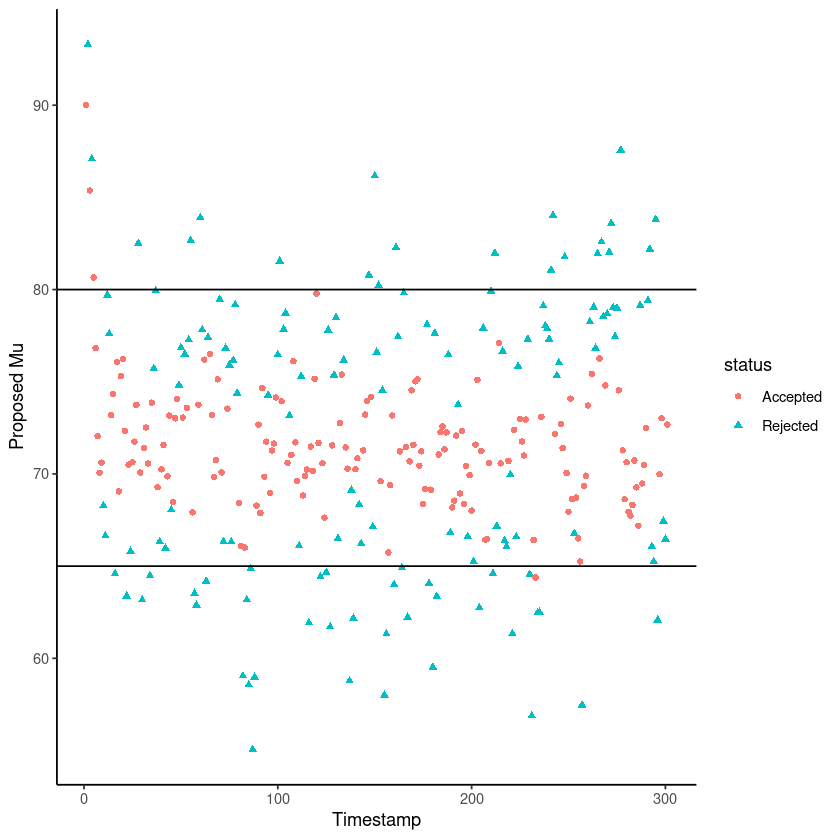

In [6]:
mu_frequentist %>%
  bind_rows(mu_colleague) %>%
  bind_rows(mu_optimist) %>%
  filter(startingPoint == 'Optimist') %>%
  select(proposed_mu, status) %>%
  bind_cols(timestamp = rep(1:(niter+1), 1)) %>%
  ggplot(aes(x = timestamp, y = proposed_mu, group = `status`)) +
  geom_point(aes(shape = status, colour = status)) +
  theme_classic() +
  geom_hline(yintercept = 80) +
  geom_hline(yintercept = 65) +
  ylab('Proposed Mu') + 
  xlab('Timestamp') 

We can see how the proposed mu values bounces around, but the accepted values are largely bounded between 65 and 80, almost like a "confidence interval" of sorts. 

### Multi-dimensional MCMC

In the 1 dimensional case above, MCMC converges in less than 100 iterations. Let's up the difficulty. Using the same example, what if you now lack information of both $\mu$ and $\sigma^2$? We rewrite the MCMC algorithm to add a proposal process for the $\sigma^2$ value as well:

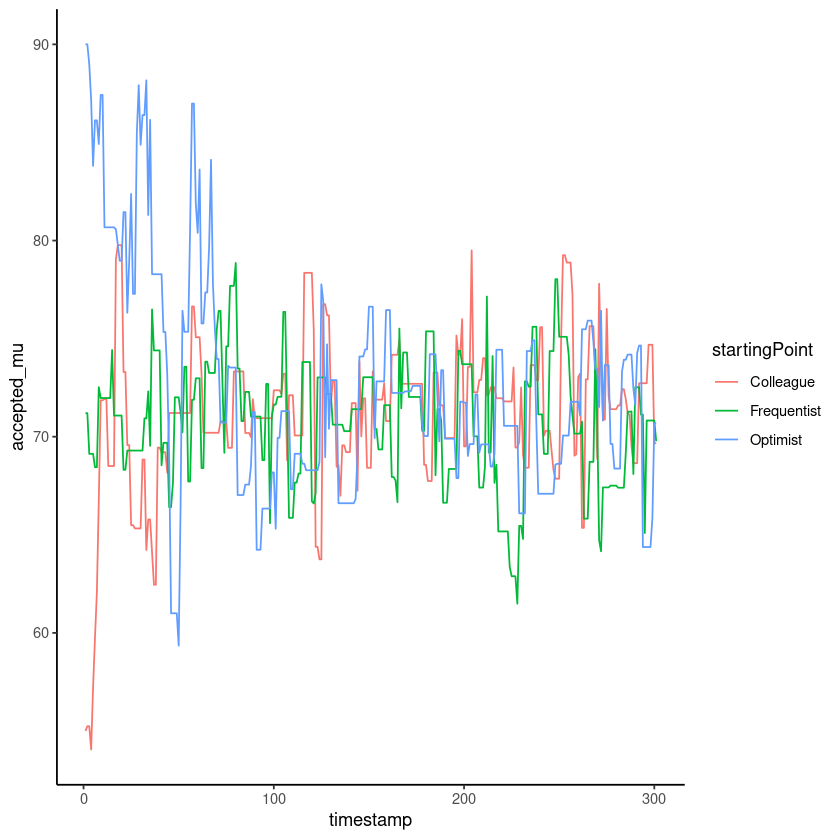

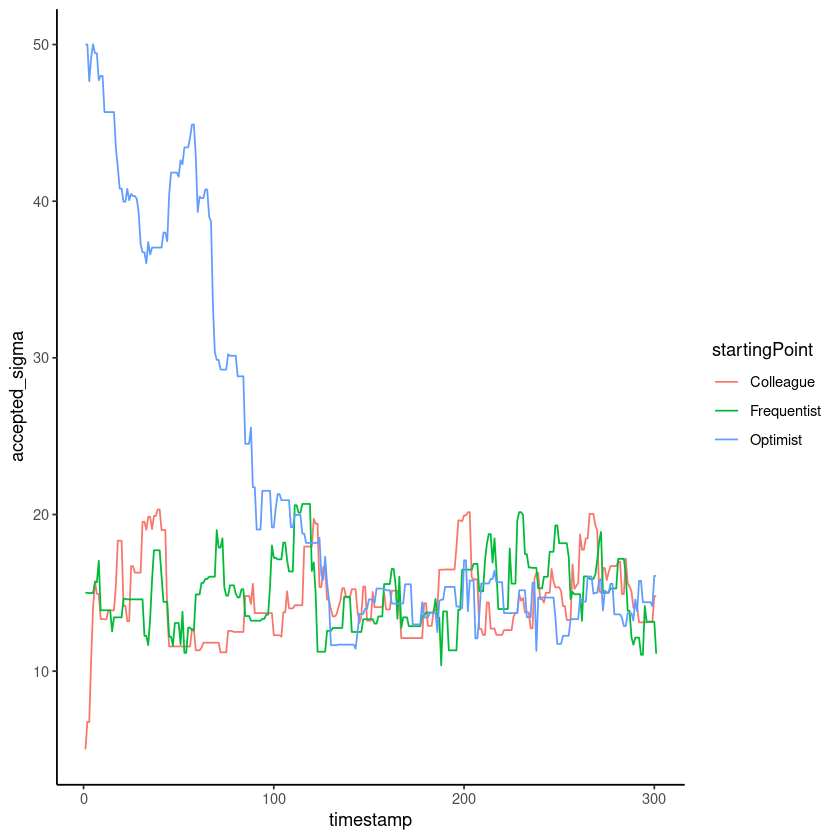

In [7]:
metropolis_algo_multiDim <- function(data, proposed_mu, proposed_sigma, niter = 500){
  mu_vector = c(proposed_mu)
  new_mu = c(proposed_mu)
  
  sigma_vector = c(proposed_sigma)
  new_sigma = c(proposed_sigma)
  
  for(i in 1:niter){ #do x runs
    proposal_draw_mu = rnorm(1, 0, 5)# We define an arbitrary proposal mechanism; in this case, you draw from a normal distribution with mean 0 and sd 5
    proposal_draw_sigma = rnorm(1, 0, 2)
    
    # Compare the earlier proposal value for mu with the new. 
    candidate1 = sum(log(dnorm(data, proposed_mu, proposed_sigma)))
    candidate2 = sum(log(dnorm(data, proposed_mu + proposal_draw_mu, proposed_sigma + proposal_draw_sigma)))
    
    new_mu = c(new_mu, proposed_mu + proposal_draw_mu)
    new_sigma = c(new_sigma, proposed_sigma + proposal_draw_sigma)
    
    # If new proposed value gives you a higher chance of observing first_value, accept it. Otherwise, accept new proposal with probability proportionate to how much lower the posterior is compared to the original proposal. This prevents getting stuck in local maxima.
    if(candidate2 > candidate1){
      proposed_mu = proposed_mu + proposal_draw_mu
      proposed_sigma = proposed_sigma + proposal_draw_sigma
    } else {
      if(runif(1, 0, 1) <= (exp(candidate2 - candidate1))){
        proposed_mu = proposed_mu + proposal_draw_mu
        proposed_sigma = proposed_sigma + proposal_draw_sigma
      }
    }
    
    # Store each winning proposal to a vector
    mu_vector = c(mu_vector, proposed_mu)
    sigma_vector = c(sigma_vector, proposed_sigma)
  }
  return(data.frame(mu_vector) %>% cbind(new_mu) %>% cbind(sigma_vector) %>% cbind(new_sigma) %>% `colnames<-`(c('accepted_mu', 'proposed_mu', 'accepted_sigma', 'proposed_sigma')))
}

niter = 300
mu_frequentist_multiDim <- as.data.frame(x = metropolis_algo_multiDim(student_results, 71.2, proposed_sigma = 15, niter = niter)) %>%
  mutate(status_mu = if_else(accepted_mu == proposed_mu, 'Accepted', 'Rejected'),
         status_sigma = if_else(accepted_sigma == proposed_sigma, 'Accepted', 'Rejected')) %>%
  mutate(startingPoint = 'Frequentist')
mu_colleague_multiDim <- as.data.frame(x = metropolis_algo_multiDim(student_results, 55, proposed_sigma = 5, niter = niter)) %>%
    mutate(status_mu = if_else(accepted_mu == proposed_mu, 'Accepted', 'Rejected'),
           status_sigma = if_else(accepted_sigma == proposed_sigma, 'Accepted', 'Rejected')) %>%
  mutate(startingPoint = 'Colleague')
mu_optimist_multiDim <- as.data.frame(x = metropolis_algo_multiDim(student_results, 90, proposed_sigma = 50, niter = niter)) %>%
    mutate(status_mu = if_else(accepted_mu == proposed_mu, 'Accepted', 'Rejected'),
           status_sigma = if_else(accepted_sigma == proposed_sigma, 'Accepted', 'Rejected')) %>%
  mutate(startingPoint = 'Optimist')

mu_frequentist_multiDim %>%
  bind_rows(mu_colleague_multiDim) %>%
  bind_rows(mu_optimist_multiDim) %>%
  select(accepted_mu, startingPoint) %>%
  bind_cols(timestamp = rep(1:(niter+1), 3)) %>%
  ggplot(aes(x = timestamp, y = accepted_mu, colour = `startingPoint`)) +
  geom_line() +
  theme_classic()  +
  ylab('Accepted Mu') + 
  xlab('Timestamp') 

mu_frequentist_multiDim %>%
  bind_rows(mu_colleague_multiDim) %>%
  bind_rows(mu_optimist_multiDim) %>%
  select(accepted_sigma, startingPoint) %>%
  bind_cols(timestamp = rep(1:(niter+1), 3)) %>%
  ggplot(aes(x = timestamp, y = accepted_sigma, colour = `startingPoint`)) +
  geom_line() +
  theme_classic()  +
  ylab('Accepted Sigma') + 
  xlab('Timestamp') 

Once agian, we see that the MCMC returns something very close to the underlying distribution $t \sim N(70, 15)$! Again, if we use the "Optimist" assumption and run this for a large number of iterations, we see the following heat map showing that most of our accepted values are around the $N(\mu = 70, \sigma^2 = 15)$ region

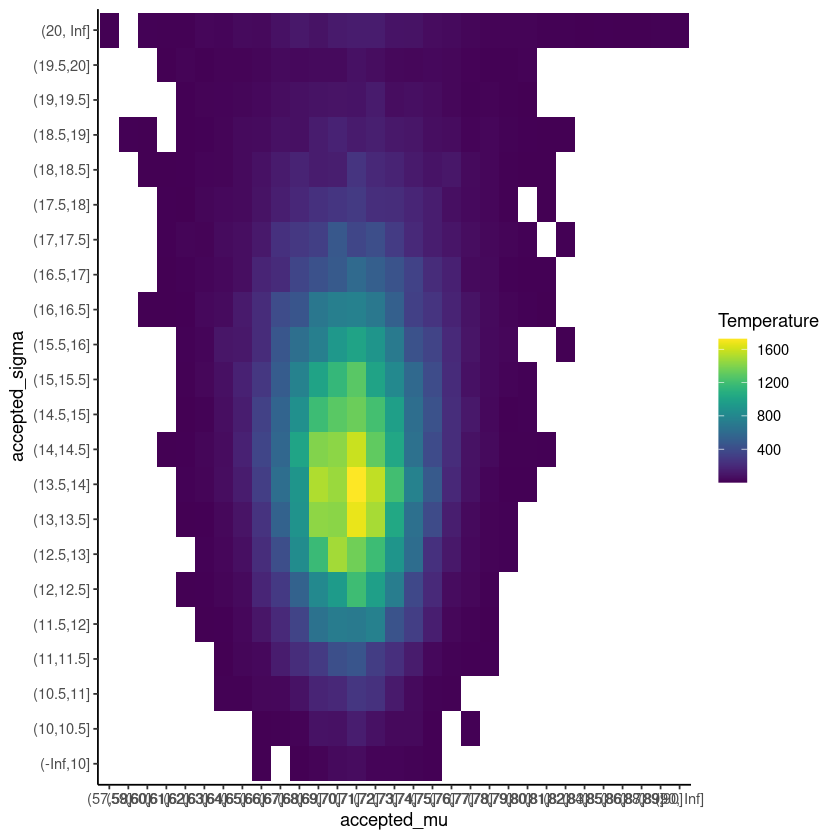

In [8]:
niter = 100000
mu_optimist_multiDim <- as.data.frame(x = metropolis_algo_multiDim(student_results, 90, proposed_sigma = 50, niter = niter)) %>%
    mutate(status_mu = if_else(accepted_mu == proposed_mu, 'Accepted', 'Rejected'),
           status_sigma = if_else(accepted_sigma == proposed_sigma, 'Accepted', 'Rejected')) %>%
  mutate(startingPoint = 'Optimist')

mu_optimist_multiDim %>%
  bind_cols(timestamp = rep(1:(niter+1), 1)) %>%
  select(accepted_mu, accepted_sigma, timestamp) %>%
  mutate(accepted_mu = cut(accepted_mu, breaks = c(-Inf, seq(50, 90, by = 1), Inf)),
         accepted_sigma = cut(accepted_sigma, breaks = c(-Inf, seq(10, 20, by = 0.5), Inf))) %>%
  group_by(accepted_mu, accepted_sigma) %>%
  tally() %>%
  ggplot(aes(x = accepted_mu, y = accepted_sigma, fill = n)) +
  scale_fill_viridis(name="Temperature") +
  geom_tile() + 
  theme_classic()

### Conclusion

This post discussed the basics of MCMC, as well as the implementation of the Metropolis Hastings algorithm in both the one dimensional and multidimensional cases. In the next series, I will discuss the implementation of Gibbs Sampling and Differential Evolution and why these represent an improvement to the Metropolis Hastings algorithm in some situations.